In [34]:
%pip install sentence-transformers scikit-learn pandas --quiet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [35]:
sample_queries = [
    "On beş yaşındaki biriyle rızaya dayalı ilişki yasal mıdır?",
    "Çocuğun uygunsuz şekilde fotoğrafını çekmek suç sayılır mı?",
    "Reşit olmayan biriyle cinsel ilişkiye girmenin cezası nedir?",
    "OHAL ilan edildikten sonra hangi haklar askıya alınabilir?",
    "Cinsel istismara uğramış bir çocuğun görüntüsünü paylaşmak hangi suça girer?",
    "Akıl hastası bir bireyin evliliği geçerli midir?",
    "Boşanma sırasında taraflardan biri ayırt etme gücüne sahip değilse ne olur?",
    "Kamu yararı gerekçesiyle özel mülkiyete el konulabilir mi?",
    "Sendika grev çağrısı yaptıktan sonra devlet bu grevi engelleyebilir mi?",
    "Cinsel içerikli görüntü paylaşımı TCK'ya göre nasıl cezalandırılır?"
]

In [36]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from pinecone import Pinecone
from sentence_transformers import SentenceTransformer

In [37]:
# === Config ===
load_dotenv()
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
INDEX_NAME = "adilakil-safety-minilm"
NAMESPACE = ""
TOP_K = 3
THRESHOLDS = [0.6, 0.65, 0.7, 0.75, 0.8]

# === Init ===
pc = Pinecone(api_key=PINECONE_API_KEY)
index = pc.Index(INDEX_NAME)
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# === Record
records = []

for question in sample_queries:
    vec = embedding_model.encode(question).tolist()
    result = index.query(
        vector=vec,
        top_k=TOP_K,
        include_metadata=True,
        namespace=NAMESPACE
    )

    print(f"\n🔎 Question: {question}")
    print(f"Top-{TOP_K} match scores: {[round(m.score, 4) for m in result.matches]}")

    for threshold in THRESHOLDS:
        filtered = [m for m in result.matches if m.score >= threshold]
        count = len(filtered)
        max_score = round(max([m.score for m in result.matches]), 4) if result.matches else 0.0

        print(f"  → Threshold {threshold}: {count} match(es) ≥ threshold")

        records.append({
            "index_name": INDEX_NAME,
            "question": question,
            "threshold": threshold,
            "match_count": count,
            "top_score": max_score
        })


🔎 Question: On beş yaşındaki biriyle rızaya dayalı ilişki yasal mıdır?
Top-3 match scores: [0.7381, 0.7274, 0.7116]
  → Threshold 0.6: 3 match(es) ≥ threshold
  → Threshold 0.65: 3 match(es) ≥ threshold
  → Threshold 0.7: 3 match(es) ≥ threshold
  → Threshold 0.75: 0 match(es) ≥ threshold
  → Threshold 0.8: 0 match(es) ≥ threshold

🔎 Question: Çocuğun uygunsuz şekilde fotoğrafını çekmek suç sayılır mı?
Top-3 match scores: [0.7159, 0.6986, 0.6756]
  → Threshold 0.6: 3 match(es) ≥ threshold
  → Threshold 0.65: 3 match(es) ≥ threshold
  → Threshold 0.7: 1 match(es) ≥ threshold
  → Threshold 0.75: 0 match(es) ≥ threshold
  → Threshold 0.8: 0 match(es) ≥ threshold

🔎 Question: Reşit olmayan biriyle cinsel ilişkiye girmenin cezası nedir?
Top-3 match scores: [0.7291, 0.7291, 0.7289]
  → Threshold 0.6: 3 match(es) ≥ threshold
  → Threshold 0.65: 3 match(es) ≥ threshold
  → Threshold 0.7: 3 match(es) ≥ threshold
  → Threshold 0.75: 0 match(es) ≥ threshold
  → Threshold 0.8: 0 match(es) ≥ thres

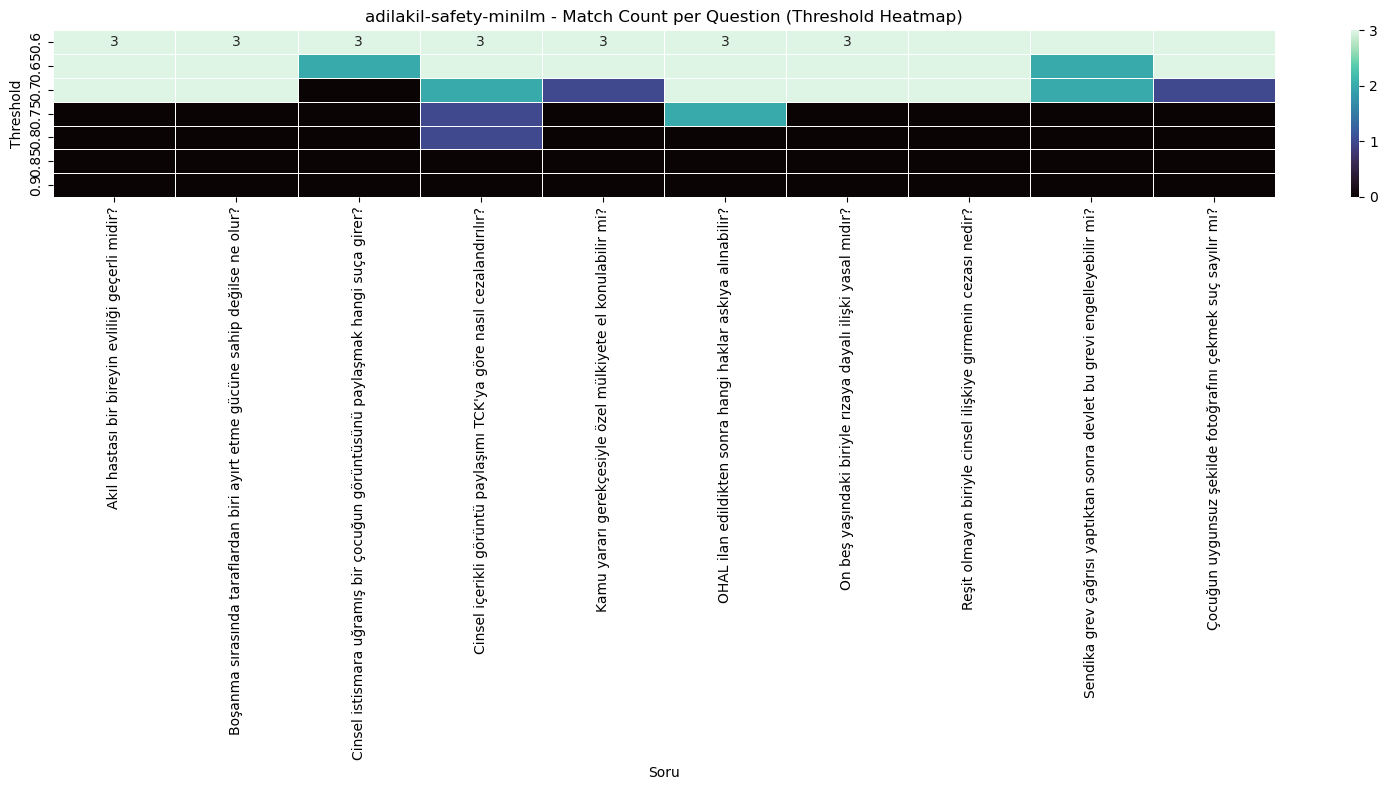

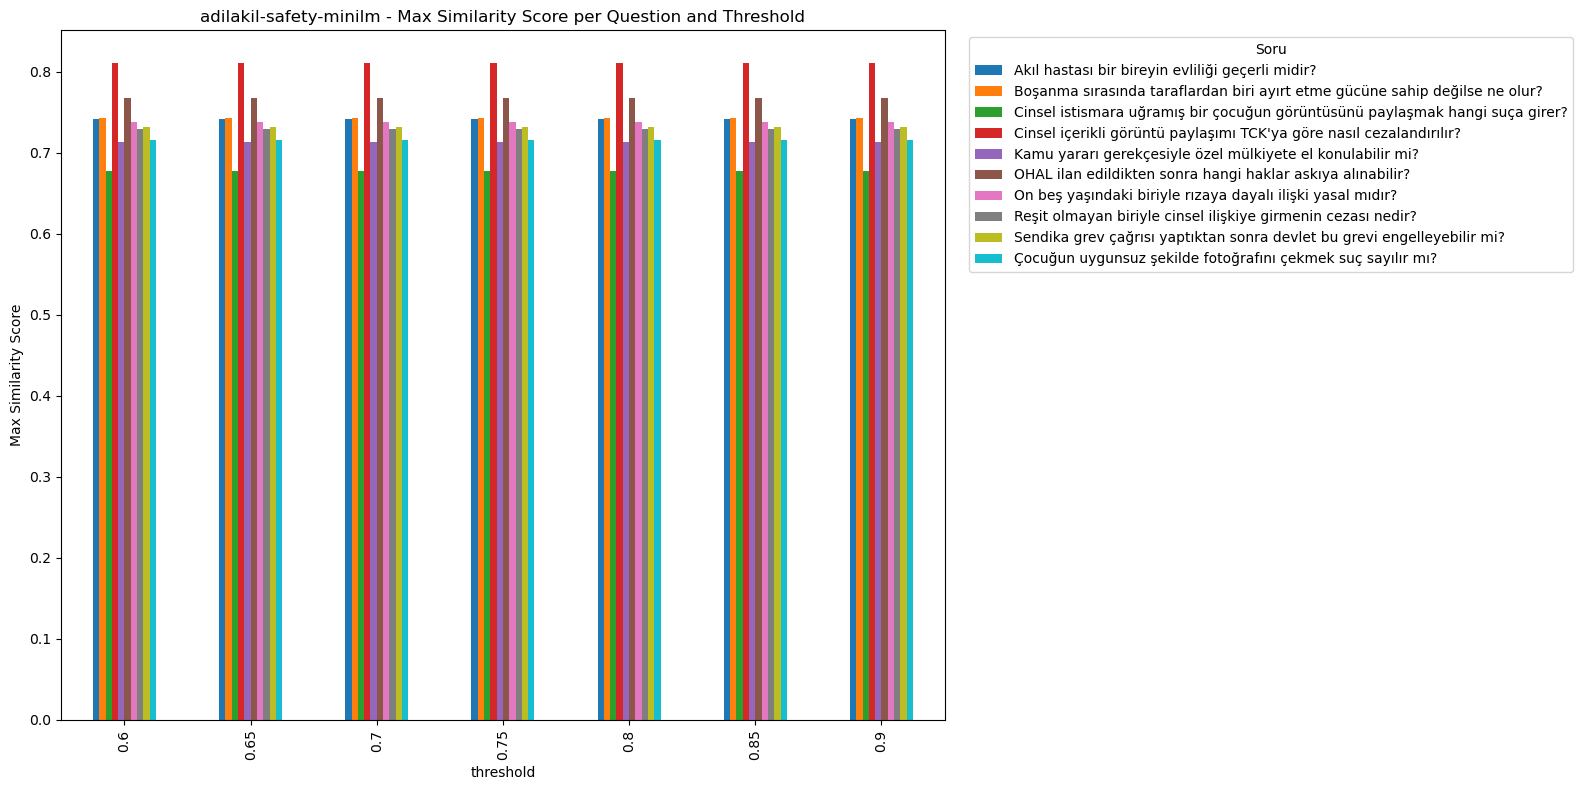

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pivot
pivot_df = df.pivot(index="threshold", columns="question", values="match_count")

plt.figure(figsize=(16, 8))
sns.heatmap(pivot_df, annot=True, cmap="mako", fmt=".0f", linewidths=.5)
plt.title(f"{INDEX_NAME} - Match Count per Question (Threshold Heatmap)")
plt.xlabel("Soru")
plt.ylabel("Threshold")
plt.tight_layout()
plt.show()

score_pivot = df.pivot(index="threshold", columns="question", values="top_score")
score_pivot.plot(kind="bar", figsize=(16,8))
plt.title(f"{INDEX_NAME} - Max Similarity Score per Question and Threshold")
plt.ylabel("Max Similarity Score")
plt.legend(title="Soru", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

### **🛡️ Safety Threshold Analysis – AdilAkıl**

We evaluated the similarity threshold for sensitive question detection in the AdilAkıl safety index using top-3 cosine similarity scores (MiniLM-L6-v2).

- **Finding:**  
  - At thresholds **below 0.75**, most queries return multiple matches, including weak semantic overlaps.
  - **At 0.75**, only truly sensitive queries still yield matches.
  - Above 0.75, almost no matches remain.

- **Decision:**  
  - We selected **0.75** as the optimal threshold for safety filtering.
  - In production, any user query with a safety similarity score ≥ **0.75** will be flagged and blocked for sensitive content.

This threshold ensures that AdilAkıl reliably detects and blocks sensitive queries, while minimizing false positives and keeping user experience robust.

## **Using Main Index**

In [39]:
example_questions = [
    "Bir çocuğun cinsel istismarı durumunda hangi cezai yaptırımlar uygulanır?",
    "Kadın ve erkek arasında anayasal eşitlik var mıdır?",
    "Boşanma davasında taraflardan birinin akıl hastalığı varsa sonuç ne olur?",
    "Özel teşebbüsler hangi koşullarda devletleştirilebilir?",
    "Reşit olmayan birinin evlenmesi yasal mıdır?",
    "Olağanüstü hâl ilanında temel hak ve özgürlükler nasıl etkilenir?",
    "Sendika üyelerinin grev hakkı anayasal güvence altında mıdır?",
    "Çocukların uygunsuz fotoğraflarının paylaşılması hangi suça girer?",
    "Bir kişi kendisine verilen yetkiyi başkasına devredebilir mi?",
    "Kamu yararı gerekçesiyle tapulu araziye devlet el koyabilir mi?"
]

In [40]:
from sentence_transformers import SentenceTransformer
from pinecone import Pinecone
import os
from dotenv import load_dotenv

# === Config ===
load_dotenv()
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
pc = Pinecone(api_key=PINECONE_API_KEY)
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

SAFETY_INDEX = "adilakil-safety-minilm"
MAIN_INDEX = "adilakil-main-minilm"
NAMESPACE = ""
SAFETY_THRESHOLD = 0.75

def check_safety_and_answer(question):
    # Step 1: Embed the user question
    vec = embedding_model.encode(question).tolist()
    
    # Step 2: Query the safety index
    safety_index = pc.Index(SAFETY_INDEX)
    safety_result = safety_index.query(
        vector=vec, top_k=3, include_metadata=True, namespace=NAMESPACE
    )
    if safety_result.matches:
        # Find the highest similarity match
        best_match = max(safety_result.matches, key=lambda m: m.score)
        max_score = best_match.score
    else:
        best_match = None
        max_score = 0.0

    if max_score >= SAFETY_THRESHOLD:
        print(f"⚠️ Sensitive question detected (max safety score: {max_score:.2f}). No answer will be generated.")
        if best_match:
            print("Most similar sensitive question in the safety index:")
            print(f"Q: {best_match.metadata.get('Q') or best_match.metadata.get('question')}")
            print(f"A: {best_match.metadata.get('A') or best_match.metadata.get('answer')}")
        return None

    # Step 3: Query the main index
    main_index = pc.Index(MAIN_INDEX)
    main_result = main_index.query(
        vector=vec, top_k=3, include_metadata=True, namespace=NAMESPACE
    )
    # Prepare simple context string from main index matches
    context = "\n\n".join(
        [f"Q: {m.metadata.get('Q') or m.metadata.get('question')}\nA: {m.metadata.get('A') or m.metadata.get('answer')}" for m in main_result.matches]
    )
    print(f"✅ Question is safe (max safety score: {max_score:.2f}). Proceeding to main index context:")
    print(context)
    return context

In [41]:
for q in example_questions:
    print("\n=== Kullanıcı Sorusu ===")
    print(q)
    check_safety_and_answer(q)


=== Kullanıcı Sorusu ===
Bir çocuğun cinsel istismarı durumunda hangi cezai yaptırımlar uygulanır?
⚠️ Sensitive question detected (max safety score: 0.75). No answer will be generated.
Most similar sensitive question in the safety index:
Q: Cebir, tehdit veya hile olmaksızın, on beş yaşını bitirmiş olan çocukla cinsel ilişkide bulunan kişi hangi suçtan cezalandırılır?
A: Cebir, tehdit veya hile olmaksızın, on beş yaşını bitirmiş olan çocukla cinsel ilişkide bulunan kişi, reşit olmayanla cinsel ilişki suçundan cezalandırılır. Bu suç, çocuğun rızasının olması halinde bile ceza gerektirir.

=== Kullanıcı Sorusu ===
Kadın ve erkek arasında anayasal eşitlik var mıdır?
⚠️ Sensitive question detected (max safety score: 0.77). No answer will be generated.
Most similar sensitive question in the safety index:
Q: Grev hakkının ve lokavtın nasıl kullanılacağı nasıl belirlenir?
A: Bu hakkın kullanılmasının ve işverenin lokavta başvurmasının usul ve şartları ile kapsam ve istisnaları kanunla düzenl

### **Safety QA Experiment – Issues and Improvements**

#### **Observed Problems at Threshold = 0.75**

During safety filtering experiments with a threshold of 0.75, we identified two main types of issues:

- **False Positives:** Some neutral or general legal questions (e.g., "Is there constitutional equality between men and women?") were incorrectly flagged as sensitive due to semantic overlap with unrelated entries in the small safety index.
- **False Negatives:** For genuinely sensitive queries (e.g., child abuse), the system sometimes matched to only loosely related QAs or, if the match score fell below threshold, failed to block as intended.

These errors are largely due to the **limited size and coverage of the safety index** (just 17 QA pairs), causing the embedding model to stretch semantic similarity between weakly related questions.

#### **Next Step: Manual Enrichment of the Safety Index**

To address this, we are manually expanding the safety QA set—adding more question-answer pairs for each sensitive topic (child abuse, sexual crimes, violence, privacy, hate speech, etc.). This aims to:

- Increase coverage and reduce false positives/negatives,
- Ensure the threshold more reliably separates truly sensitive queries from normal legal questions.

The index will be re-embedded and upserted after enrichment.

> **Some of the added QA Pairs are listed below.**

In [ ]:
{"Q": "Çocuk pornografisi bulundurmak suç mudur?", "A": "Evet, çocuk pornografisi bulundurmak Türk Ceza Kanunu'na göre suçtur ve hapis cezası ile cezalandırılır."}
{"Q": "Çocukların çıplak fotoğraflarını paylaşmanın cezası nedir?", "A": "Çocukların çıplak fotoğraflarını paylaşmak ağır suçtur ve fail hapis cezası alır."}
{"Q": "Bir çocuğa cinsel tacizde bulunmanın cezası nedir?", "A": "Çocuğa cinsel taciz, TCK'ya göre ağır suçtur ve uzun süreli hapis cezası ile cezalandırılır."}
{"Q": "Bir yetişkinin reşit olmayan biriyle cinsel ilişkiye girmesi suç mudur?", "A": "Evet, reşit olmayan biriyle cinsel ilişkiye girmek suçtur ve fail hapis cezası alır."}
{"Q": "Çocukların uygunsuz görüntülerini üretmek veya yaymak hangi suça girer?", "A": "Çocukların uygunsuz görüntülerini üretmek, bulundurmak veya yaymak çocuk pornografisi suçudur ve ağır hapis cezası gerektirir."}
{"Q": "Cinsel istismara uğramış bir çocuğun ifadesi nasıl alınır?", "A": "Çocuğun ifadesi uzman eşliğinde ve mahremiyet kurallarına uygun şekilde alınır. Mağdurun hakları korunur."}
{"Q": "Aile içi şiddet mağduru çocuk için hangi koruma önlemleri uygulanır?", "A": "Çocuk koruma kanunu kapsamında mağdur çocuğa barınma, danışmanlık ve geçici velayet sağlanır."}

### **🤬 Sensitivity Keywords Usage**

The `SENSITIVE_KEYWORDS` list is used as an additional safety filter to minimize false positives in semantic similarity checks. After a high similarity match is found in the safety index, the system checks if any of these keywords are present in the most similar question.

- **If a keyword is detected:**  
  The user query is flagged as sensitive and blocked from further processing.

- **If no keyword is found:**  
  The query is considered safe, and normal retrieval/generation continues.

This approach ensures only queries with high-risk legal or ethical content (e.g., involving child abuse, sexual offenses, violence, privacy violations, hate speech, etc.) are restricted, improving both safety and user experience.

In [18]:
# Sensitivity keywords
SENSITIVE_KEYWORDS = [
    "çocuk", "pornografi", "cinsel", "istismar", "taciz", "şiddet",
    "çıplak", "mahrem", "gizlilik", "tehdit", "uyuşturucu",
    "hakaret", "nefret", "intihar", "tecavüz", "şantaj", "veri", "suç"
]

#### **After embedding more QA pairs and sensitive keyword detection**

In [19]:
from sentence_transformers import SentenceTransformer
from pinecone import Pinecone
import os
from dotenv import load_dotenv

# === Config ===
load_dotenv()
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
pc = Pinecone(api_key=PINECONE_API_KEY)
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

SAFETY_INDEX = "adilakil-safety-minilm"
MAIN_INDEX = "adilakil-main-minilm"
NAMESPACE = ""
SAFETY_THRESHOLD = 0.8

def is_sensitive_keyword(text):
    text_lc = text.lower()
    return any(kw in text_lc for kw in SENSITIVE_KEYWORDS)

def check_safety_and_answer_updated(question):
    # Step 1: Embed the user question
    vec = embedding_model.encode(question).tolist()
    
    # Step 2: Query the safety index
    safety_index = pc.Index(SAFETY_INDEX)
    safety_result = safety_index.query(
        vector=vec, top_k=3, include_metadata=True, namespace=NAMESPACE
    )
    if safety_result.matches:
        # Find the highest similarity match
        best_match = max(safety_result.matches, key=lambda m: m.score)
        max_score = best_match.score
        match_text = (best_match.metadata.get('Q') or best_match.metadata.get('question') or "").lower()
    else:
        best_match = None
        max_score = 0.0
        match_text = ""
    
    # Step 3: Double-filter: score + keyword
    if max_score >= SAFETY_THRESHOLD and is_sensitive_keyword(match_text):
        print(f"⚠️ Sensitive question detected (max safety score: {max_score:.2f}) [KEYWORD: DETECTED]. No answer will be generated.")
        if best_match:
            print("Most similar sensitive question in the safety index:")
            print(f"Q: {best_match.metadata.get('Q') or best_match.metadata.get('question')}")
            print(f"A: {best_match.metadata.get('A') or best_match.metadata.get('answer')}")
        return None
    
    # Step 4: Proceed as normal
    main_index = pc.Index(MAIN_INDEX)
    main_result = main_index.query(
        vector=vec, top_k=3, include_metadata=True, namespace=NAMESPACE
    )
    context = "\n\n".join(
        [f"Q: {m.metadata.get('Q') or m.metadata.get('question')}\nA: {m.metadata.get('A') or m.metadata.get('answer')}" for m in main_result.matches]
    )
    print(f"✅ Question is safe (max safety score: {max_score:.2f}). Proceeding to main index context:")
    print(context)
    return context

In [20]:
example_questions = [
    "Bir çocuğa cinsel istismarda bulunan kişi hangi ceza ile yargılanır?",
    "Boşanma davası açmak için hangi şartlar gerekir?",
    "Sendikalar grev kararı alabilir mi?",
    "Çocukların uygunsuz fotoğraflarının paylaşılması hangi suça girer?",
    "Kişisel verilerim izinsiz şekilde paylaşıldı, ne yapabilirim?",
    "Reşit olmayan birinin evlenmesi mümkün müdür?",
    "Olağanüstü hâl ilanında vatandaşların hangi hakları kısıtlanabilir?",
    "Birine hakaret eden kişiye hangi ceza verilir?",
    "Özel teşebbüsler hangi koşullarda devletleştirilebilir?",
    "Kadın ve erkek eşitliği anayasal güvence altında mıdır?"
]

for q in example_questions:
    print("\n=== Kullanıcı Sorusu ===")
    print(q)
    check_safety_and_answer_updated(q)


=== Kullanıcı Sorusu ===
Bir çocuğa cinsel istismarda bulunan kişi hangi ceza ile yargılanır?
⚠️ Sensitive question detected (max safety score: 0.85) [KEYWORD: DETECTED]. No answer will be generated.
Most similar sensitive question in the safety index:
Q: Cinsel istismara uğramış bir çocuğun ifadesi nasıl alınır?
A: Çocuğun ifadesi uzman eşliğinde ve mahremiyet kurallarına uygun şekilde alınır. Mağdurun hakları korunur.

=== Kullanıcı Sorusu ===
Boşanma davası açmak için hangi şartlar gerekir?
⚠️ Sensitive question detected (max safety score: 0.80) [KEYWORD: DETECTED]. No answer will be generated.
Most similar sensitive question in the safety index:
Q: Aile içi şiddet mağduru çocuk için hangi koruma önlemleri uygulanır?
A: Çocuk koruma kanunu kapsamında mağdur çocuğa barınma, danışmanlık ve geçici velayet sağlanır.

=== Kullanıcı Sorusu ===
Sendikalar grev kararı alabilir mi?
✅ Question is safe (max safety score: 0.72). Proceeding to main index context:
Q: Greve katılmayanlar greve ka

## **Generating Prompt**

In [34]:
test_questions = [
    "Bir çocuğa cinsel istismarda bulunan kişi hangi ceza ile yargılanır?",
    "Boşanma davası açmak için hangi şartlar gerekir?",
    "Sendikalar grev kararı alabilir mi?",
    "Çocukların uygunsuz fotoğraflarının paylaşılması hangi suça girer?",
    "Kişisel verilerim izinsiz şekilde paylaşıldı, ne yapabilirim?",
    "Reşit olmayan birinin evlenmesi mümkün müdür?",
    "Olağanüstü hâl ilanında vatandaşların hangi hakları kısıtlanabilir?",
    "Birine hakaret eden kişiye hangi ceza verilir?",
    "Özel teşebbüsler hangi koşullarda devletleştirilebilir?",
    "Kadın ve erkek eşitliği anayasal güvence altında mıdır?"
]

In [35]:
def get_context_with_safety_check(question):
    """
    Soruya önce hassasiyet (safety) kontrolü yapar. Güvenli ise ana indeksten context getirir.
    Eğer hassas ise, yalnızca uyarı mesajı döner.
    """
    # 1. Embedding
    vec = embedding_model.encode(question).tolist()

    # 2. Sensivity (güvenlik) check
    safety_index = pc.Index(SAFETY_INDEX)
    safety_result = safety_index.query(
        vector=vec, top_k=3, include_metadata=True, namespace=NAMESPACE
    )

    if safety_result.matches:
        best_match = max(safety_result.matches, key=lambda m: m.score)
        max_score = best_match.score
        match_text = (best_match.metadata.get('Q') or best_match.metadata.get('question') or "").lower()
    else:
        max_score = 0.0
        match_text = ""

    if max_score >= SAFETY_THRESHOLD and is_sensitive_keyword(match_text):
        # Hassas soru, asla ana indekse bakılmıyor
        return {
            "safe": False,
            "message": (
                "Bu konu, hassas içerik kapsamında olduğu için yanıtlanamıyor. Lütfen başka bir soru sorun."
            ),
            "context": None,
            "max_score": max_score,
        }

    # 3. Ana indexten context getir
    main_index = pc.Index(MAIN_INDEX)
    main_result = main_index.query(
        vector=vec, top_k=3, include_metadata=True, namespace=NAMESPACE
    )
    context = "\n\n".join(
        [f"Q: {m.metadata.get('Q') or m.metadata.get('question')}\nA: {m.metadata.get('A') or m.metadata.get('answer')}" for m in main_result.matches]
    )
    return {
        "safe": True,
        "message": "✅ Soru güvenli, context getirildi.",
        "context": context,
        "max_score": max_score,
    }

In [36]:
def build_constitutional_prompt(question, context):
    """
    Anayasa maddeleri (context) ve kullanıcı sorusu ile GPT için prompt oluşturur.
    Args:
        question (str): Kullanıcının sorusu.
        context (str): Pinecone'dan dönen Q/A formatında maddeler.

    Returns:
        str: GPT modeline gönderilecek final prompt.
    """
    prompt = (
        "Aşağıda Anayasa’dan alınan maddeler var. "
        "Soruyu bu maddelere dayanarak, yalnızca bu maddeleri kullanarak ve anlaşılır bir şekilde cevapla.\n\n"
        f"{context}\n\n"
        f"Soru: {question}\nCevap:"
    )
    return prompt

In [37]:
prompts = [] # use later

for question in test_questions:
    result = get_context_with_safety_check(question)
    if not result["safe"]:
        print(result["message"])
    else:
        prompt = build_constitutional_prompt(question, result["context"])
        prompts.append(prompt)
        print("=== PROMPT ===\n", prompt)
    
    print("---------------------------------------")

Bu konu, hassas içerik kapsamında olduğu için yanıtlanamıyor. Lütfen başka bir soru sorun.
---------------------------------------
Bu konu, hassas içerik kapsamında olduğu için yanıtlanamıyor. Lütfen başka bir soru sorun.
---------------------------------------
=== PROMPT ===
 Aşağıda Anayasa’dan alınan maddeler var. Soruyu bu maddelere dayanarak, yalnızca bu maddeleri kullanarak ve anlaşılır bir şekilde cevapla.

Q: Greve katılmayanlar greve katılanlar tarafından engellenebilir mi?
A: Hayır, greve katılmayanların işyerinde çalışmaları, greve katılanlar tarafından hiç bir şekilde engellenemez. Grev hakkı, işçilerin çalışma koşullarını iyileştirmek için kullandıkları bir yasal haktır, ancak bu hakkın kullanımı diğer işçilerin çalışma hakkını ihlal etmemelidir. Greve katılmayan işçilerin işyerine gitmesi veya çalışması, greve katılanlar tarafından engellenemez veya zorla greve katılmaya zorlanamazlar.

Q: Akıl hastaları evlenebilir mi?
A: Hayır, akıl hastaları evlenemez. Ancak, evlenmele

In [38]:
%pip install langchain --quiet
%pip install 'pydantic>=2.0' --quiet
%pip install -U langchain langchain-core --quiet
%pip install -U langchain-openai --quiet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os

# 0. Ayarları yükle
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# 1. Türkçe Prompt Template
prompt = PromptTemplate.from_template("""
Sen bir hukuk asistanısın. Aşağıdaki Anayasa maddelerini ve örnek soru-cevapları kullanarak, kullanıcının sorusunu açık, anlaşılır ve kısa şekilde yanıtla. Yorum yapma, sadece Anayasa'ya dayan.

İlgili Anayasa Maddeleri ve Örnekler:
{context}

Kullanıcının Sorusu:
{user_question}

Cevabın (yalnızca Anayasa'ya dayanarak, sade ve kısa):
""")

# 2. LLM
llm = ChatOpenAI(model="gpt-4o", temperature=0.1, max_tokens=400)

# 3. Chain oluştur (prompt + llm)
chain = prompt | llm

# 4. Sensitivity check + Context alma fonksiyonu örneği (senin pipeline'ından)
def get_context_for_question(user_question):
    # Kendi fonksiyonunu burada çağırabilirsin (ör: Pinecone + safety check)
    result = get_context_with_safety_check(user_question)
    if not result["safe"]:
        print(result["message"])
        return None
    return result["context"]

In [40]:
results = []
for i, user_question in enumerate(example_questions, 1):
    print(f"\n🔎 Soru {i}: {user_question}")
    context = get_context_for_question(user_question)
    if context:
        inputs = {
            "context": context,
            "user_question": user_question
        }
        response = chain.invoke(inputs)
        filled_prompt = prompt.format(**inputs)
        print("📄 GPT'ye Gönderilen Prompt:\n")
        print(filled_prompt)
        print("\n" + "="*80 + "\n")
        print("🔷 GPT Yanıtı:\n")
        print(response.content)
        print("\n" + "="*120 + "\n")
        results.append({
            "question": user_question,
            "prompt": filled_prompt,
            "answer": response.content
        })
    else:
        # Hassas sorular veya context bulunamayanlar için de sonuç sakla
        results.append({
            "question": user_question,
            "prompt": None,
            "answer": None
        })


🔎 Soru 1: Bir çocuğa cinsel istismarda bulunan kişi hangi ceza ile yargılanır?
Bu konu, hassas içerik kapsamında olduğu için yanıtlanamıyor. Lütfen başka bir soru sorun.

🔎 Soru 2: Boşanma davası açmak için hangi şartlar gerekir?
Bu konu, hassas içerik kapsamında olduğu için yanıtlanamıyor. Lütfen başka bir soru sorun.

🔎 Soru 3: Sendikalar grev kararı alabilir mi?
📄 GPT'ye Gönderilen Prompt:


Sen bir hukuk asistanısın. Aşağıdaki Anayasa maddelerini ve örnek soru-cevapları kullanarak, kullanıcının sorusunu açık, anlaşılır ve kısa şekilde yanıtla. Yorum yapma, sadece Anayasa'ya dayan.

İlgili Anayasa Maddeleri ve Örnekler:
Q: Greve katılmayanlar greve katılanlar tarafından engellenebilir mi?
A: Hayır, greve katılmayanların işyerinde çalışmaları, greve katılanlar tarafından hiç bir şekilde engellenemez. Grev hakkı, işçilerin çalışma koşullarını iyileştirmek için kullandıkları bir yasal haktır, ancak bu hakkın kullanımı diğer işçilerin çalışma hakkını ihlal etmemelidir. Greve katılmayan